The first attempt kept crashing the kernel, so this is a more "optimized" version to not do that.

In [1]:
import gc
import typing
import warnings
warnings.filterwarnings('ignore')
%load_ext cudf.pandas
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error # contest score
# from sklearn.tree import DecisionTreeRegressor # see endnote
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(21, 8), autolayout=True)

In [2]:
def regression_imputer(data:pd.DataFrame, target:str, drops:list=[]) -> pd.DataFrame:
    X_train = data[data[target].notna()].drop(drops, axis=1)
    y_train = data[target].loc[data.index.isin(X_train.index)]
    model = LinearRegression()
    model.fit(X_train, y_train)
    X_test = data[data[target].isna()].drop(drops, axis=1).dropna()
    y_test = model.predict(X_test)
    return pd.DataFrame(y_test, columns=[target], index=X_test.index)

In [3]:
def preprocess(data:pd.DataFrame, target:str, imputes:list[str]=[], skips:list[str]=[], lags:int=0) -> pd.DataFrame:
    temp = data.copy()
    # impute
    for col in imputes:
        imp = regression_imputer(temp, col, drops=[*imputes, target])
        temp = temp.fillna(imp)
    temp = temp.interpolate()
    # normalize
    skipped = temp[[*skips, target]]
    temp = temp.drop([*skips, target], axis=1)
    temp = (temp - temp.min()) / (temp.max() - temp.min())
    # lag features
    lagged = []
    for i in range(1, lags+1):
        lag = temp.shift(i)
        lag.columns = [f'{col}_lag_{i}0s' for col in lag.columns]
        lagged.append(lag)
    # recombine
    temp = temp.join(lagged, how='inner').dropna(axis=0)
    temp = skipped.join(temp, how='inner')
    return temp

In [4]:
data = pd.read_csv('./.data/train.csv').set_index(['stock_id', 'date_id', 'seconds_in_bucket']).sort_index()

In [5]:
# data['imbalance'] = data.imbalance_size * data.imbalance_buy_sell_flag
# data = data.drop(['imbalance_size', 'imbalance_buy_sell_flag'], axis=1)

In [6]:
preprocessed = []
for stock_id in range(200):
    print(f'Preprocessing {stock_id/2:04.1f}% Complete', end='\r')
    stock_data = pd.DataFrame(data.loc[stock_id])
    stock_data = preprocess(stock_data, 'target', imputes=['far_price', 'near_price'], skips=['time_id', 'row_id', 'imbalance_buy_sell_flag'], lags=6)
    stock_data['stock_id'] = stock_id
    preprocessed.append(stock_data)
print('Preprocessing 100.0% Complete')

Preprocessing 100.0% Complete


In [7]:
gc.collect() # kernel crashes otherwise
pass

In [8]:
data = pd.concat(preprocessed).reset_index()
del preprocessed

In [9]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_id = enc.fit_transform(np.array(data.stock_id).reshape(-1, 1))
encoded = pd.DataFrame(enc_id.toarray().reshape(len(data), 200), columns=[f'stock_id_{id_}' for id_ in enc.categories_[0]])

In [10]:
data = data.drop('stock_id', axis=1).join(encoded, how='inner')
data = data.set_index('row_id')
data = data.sort_values(by=['time_id'])
del enc, enc_id, encoded

In [11]:
X = data.drop('target', axis=1)
y = data.target
del data

In [12]:
class RegressionModel(typing.Protocol): # https://stackoverflow.com/a/60542986/3178898
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...

def score_model(X:pd.DataFrame, y:pd.Series, model:RegressionModel) -> RegressionModel:
    gc.collect() # lol
    print('Splitting....', end='\r')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=25)
    print('Fitting......', end='\r')
    model.fit(X_train, y_train)
    print('Predicting...', end='\r')
    y_fit = pd.Series(model.predict(X_train), index=X_train.index)
    y_pred = pd.Series(model.predict(X_test), index=X_test.index)
    print('Scoring......', end='\r')
    train_mae = mean_absolute_error(y_train, y_fit)
    test_mae = mean_absolute_error(y_test, y_pred)
    print(f'Train MAE: {train_mae}\n Test MAE: {test_mae}')
    fig, axs = plt.subplots(2, 2, sharey=True)
    y_fit.plot(ax=axs[0][0], title='Training Fit', color='C0')
    y_train.plot(ax=axs[0][1], title='Training Actual', color='b')
    y_pred.plot(ax=axs[1][0], title='Test Prediction', color='C7')
    y_test.plot(ax=axs[1][1], title='Test Actual', color='k')
    fig.autofmt_xdate()
    return model

Train MAE: 6.359911718404313
 Test MAE: 6.35842693355862


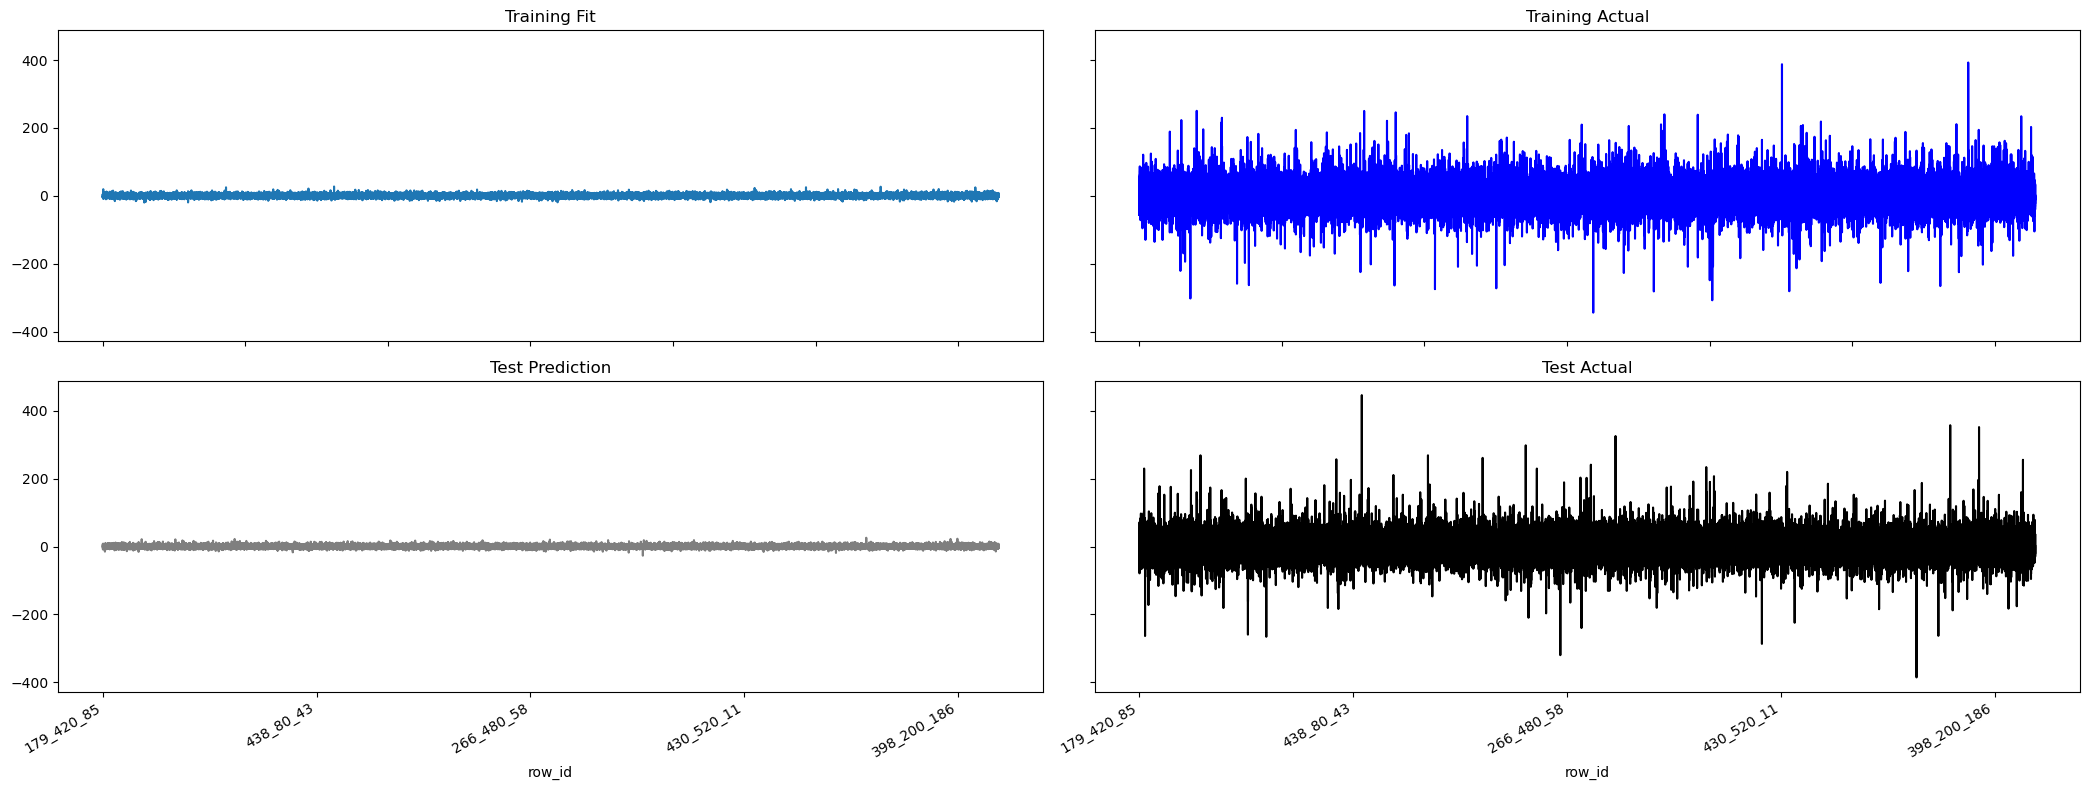

In [13]:
model = score_model(X, y, LinearRegression()) # Train: 6.371; Test: 6.369; ~3 mins @ 25% -- Train: 6.366; Test: 6.363; ~3 mins @ 33% -- Train: 6.360; Test: 6.358; ~2.5 mins @ 40%

In [14]:
# model = score_model(X, y, DecisionTreeRegressor(max_leaf_nodes=50, random_state=25)) # Train: 6.362; Test: 6.363; ~6 mins @ 25%

In [15]:
# model = score_model(X, y, DecisionTreeRegressor(max_leaf_nodes=500, random_state=25)) # Train: 6.342; Test: 6.361; ~8 mins @ 25%

^ These were slightly better but at multiples of the runtime the juice isn't worth the squeeze. Back to the drawing board.

I've hit my limits; I'm going to do some research and come back in v3 with cross-validation and possibly some NN action.